# Imports

In [109]:
import crepe
from scipy.io import wavfile
import numpy as np
import math
from pprint import pprint
import matplotlib.pyplot as plt
import os
from io import StringIO
from midiutil.MidiFile import MIDIFile
import random
import importlib

import audioconversion_util as utils

# Volume calculation

In [126]:
# loading a file from the data set to demonstrate volume calculation
directory = '../speech_data/emovdb-angry/bea/'
filename = 'anger_1-28_0016.wav'
sr, audio = wavfile.read(directory+"/"+filename)
t,f,c = utils.getPrediction(sr,audio,stepSize=5)
sampled_volume = utils.maxSampling(np.abs(audio),len(t))

29/29 [==============================] - 12s 408ms/step


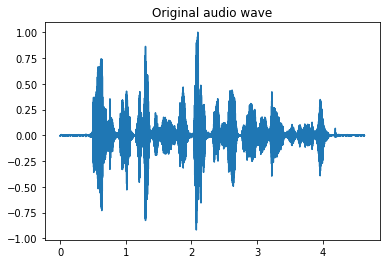

In [129]:
# visualizing the original audio wave
xs = np.arange(0,len(audio)/44100,1/44100)
plt.plot(xs, audio)
plt.title(f"Original audio wave")
plt.show()

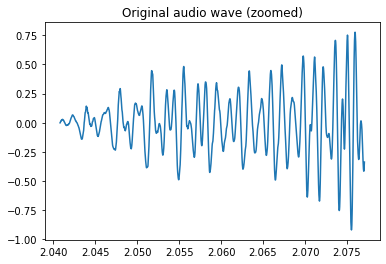

In [147]:
# visualization of a small part of the sound wave 
plt.plot(xs[90000:91600], audio[90000:91600])
plt.title(f"Original audio wave (zoomed)")
plt.show()

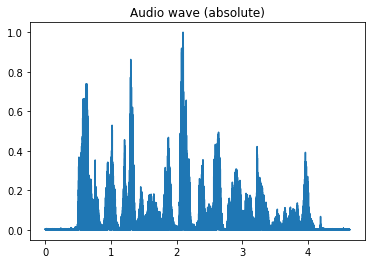

In [130]:
# visualizing the original frequency data
xs = np.arange(0,len(audio)/44100,1/44100)
plt.plot(xs, np.abs(audio))
plt.title(f"Audio wave (absolute)")
plt.show()

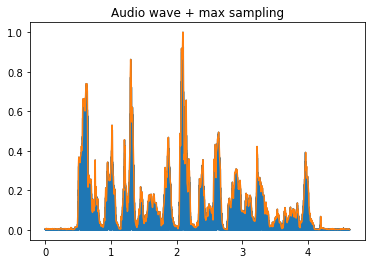

In [143]:
%matplotlib inline
xs = np.arange(0,len(audio)/44100,1/44100)
plt.plot(xs, np.abs(audio))
plt.plot(t, sampled_volume)
plt.title(f"Audio wave + max sampling")
plt.show()

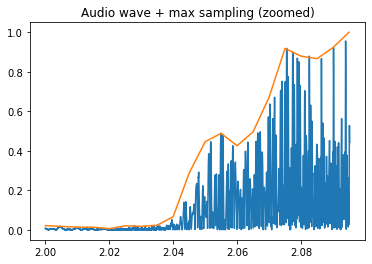

In [144]:
plt.plot(xs[88200:92400], np.abs(audio[88200:92400]))
plt.plot(t[400:420], sampled_volume[400:420])
plt.title(f"Audio wave + max sampling (zoomed)")
plt.show()

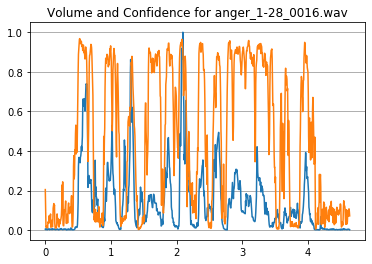

In [145]:
plt.plot(t, sampled_volume)
plt.plot(t, c)
plt.grid(axis='y', linewidth=1)
plt.title(f"Volume and Confidence for {filename}")
plt.show()

# Pitch detection

In [160]:
directory = '../speech_data/emovdb-angry/bea'
filename = 'anger_1-28_0001.wav'

notes, t, c = utils.processFile(directory,filename)

29/29 [==============================] - 11s 360ms/step


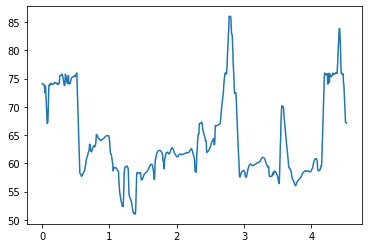

In [171]:
# plot the pitch
plt.plot(t,notes)
plt.show()

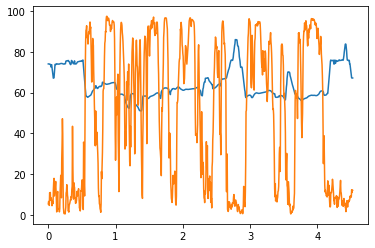

In [172]:
# plot the pitch and confidence
plt.plot(t,notes)
plt.plot(t,c*100)
plt.show()

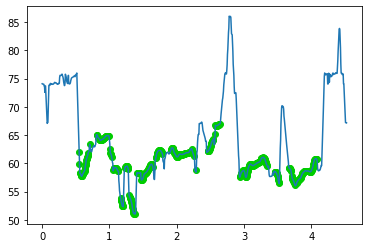

In [173]:
# highlight areas with a confidence value > 0.5
minConfidence = 0.5
notes_filtered = [note for note,conf in zip(notes,c) if conf>minConfidence]
t_filtered = [t for t,conf in zip(t,c) if conf>minConfidence]
plt.scatter(t_filtered,notes_filtered,c='#00cc00')
plt.plot(t,notes)
plt.show()

## The effect of step size

In [151]:
importlib.reload(utils)

# read file with 20ms step size
notes_20ms, t_20ms, c_20ms = utils.processFile(directory,filename,stepSize=20)
# read file with 10ms step size
notes_10ms, t_10ms, c_10ms = utils.processFile(directory,filename,stepSize=10)
# read file with 5ms step size
notes_5ms, t_5ms, c_5ms = utils.processFile(directory,filename,stepSize=5)

29/29 [==============================] - 10s 340ms/step


In [175]:
print(np.mean(c_20ms))
print(np.mean(c_10ms))
print(np.mean(c_5ms))

0.48172292
0.48187685
0.48209643


In [153]:
%matplotlib qt
plt.plot(t_20ms,c_20ms)
plt.plot(t_10ms,c_10ms)
plt.plot(t_5ms,c_5ms)
plt.show()

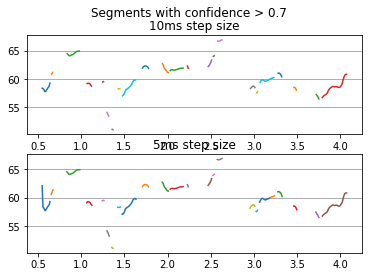

In [91]:
%matplotlib inline
importlib.reload(utils)
segments_10ms = utils.getSegments(notes,t,c)
segments_5ms = utils.getSegments(_notes,_t,_c)

fig, (ax1,ax2) = plt.subplots(2)
fig.suptitle('Segments with confidence > 0.7')

for segment in segments_10ms:
    # adjust shape so it is displayed correctly by matplotlib
    _segment = np.array(segment).T
    ax1.plot(_segment[0],_segment[1])
    
for segment in segments_5ms:
    # adjust shape so it is displayed correctly by matplotlib
    _segment = np.array(segment).T
    ax2.plot(_segment[0],_segment[1])

#plt.plot(frequency)
    

ax1.grid(axis='y', linewidth=1)
ax2.grid(axis='y', linewidth=1)
ax1.set_title('10ms step size')
ax2.set_title('5ms step size')
plt.show()

In [ ]:
# process a batch of data
directories = ['../speech_data/emovdb-angry','../speech_data/emovdb-amused','../speech_data/emovdb-neutral']
speakers = ['/bea','/jenie','/sam']
notes, files, times, conf = utils.processBatchData(directories, speakers, saveLocally = False)

In [195]:
# load data from local files

# read pitch data for all audio files
notes = utils.readList("notes")

# read file names
# file names are used for labeling only
# extension is removed for better readability
files = [f.replace(".wav","") for f in utils.readList("files")]

# read list of time steps
t = utils.readList("times")

# read list of confidence per time step
c = utils.readList("conf")

## Approach #1: Segment strings

In [54]:
# get segments for a single audio file
segments = utils.getSegments(notes[0],t[0],c[0])

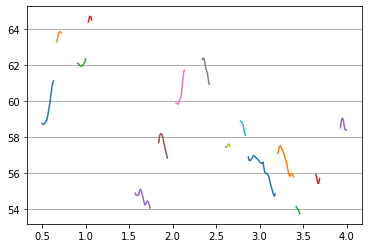

In [178]:
%matplotlib inline
for segment in segments:
    # adjust shape so it is displayed correctly by matplotlib
    _segment = np.array(segment).T
    plt.plot(_segment[0],_segment[1])

#plt.plot(frequency)
    
plt.grid(axis='y', linewidth=1)

plt.show()

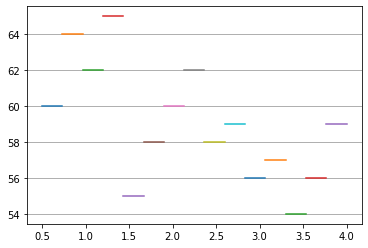

In [179]:
# visualizing the resulting simplified notes

simpleNotes = utils.segmentsToSimpleNotes(segments)
# offest is the x value of the first element of the first segment
offset = segments[0][0][0]

lastSegment = segments[len(segments)-1]

# duration of each segment is the duration between
# the first point of the first segment and the last point of the last segment divided by the amount of segments
dur = (lastSegment[len(lastSegment)-1][0]-offset)/len(segments)

for i in range(len(simpleNotes)):
    # draw one straight line for each note
    plt.plot([offset+dur*i,offset+dur*(i+1)],[simpleNotes[i],simpleNotes[i]])
    
plt.grid(axis='y', linewidth=1)
plt.show()

In [106]:
# generating the string representation of a pitch pattern

code = utils.notesToString(simpleNotes)
print(code)

<@>A7:<>:;8968;


In [122]:
# generating all string representations

segmentsList = [utils.getSegments(_notes,_t,_c) for _notes,_t,_c in zip(notes,t,c)]
simpleNotesList = [utils.segmentsToSimpleNotes(segment) for segment in segmentsList]
segmentStringList = [utils.notesToString(element) for element in simpleNotesList]
print(segmentStringList[0:3])

[';=@;54;63:;>>>>?@C;:<<=:9;', '7<:9:<;8>@977779??:998776>>A:6', 'J@?<BDA=>96667;CED=ACCGC?<8']


In [288]:
# apply clustering
importlib.reload(utils)
utils.getStringClusters(segmentStringList, files, "normal")

writing array
dist_string


c:\users\fabian\appdata\local\programs\python\python37\lib\site-packages\sklearn\cluster\_affinity_propagation.py:154: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 1.0 (renaming of 0.25) which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  FutureWarning


Exemplar: anger_1-28_0002 Elements: anger_1-28_0002
Exemplar: anger_1-28_0003 Elements: anger_1-28_0003
Exemplar: anger_1-28_0010 Elements: anger_1-28_0010
Exemplar: anger_1-28_0013 Elements: anger_1-28_0013
Exemplar: anger_1-28_0016 Elements: amused_1-15_0001, amused_57-84_0064, amused_57-84_0074, anger_1-28_0016, anger_1-28_0024, anger_113-140_0122, anger_113-140_0128, anger_85-112_0095
Exemplar: anger_1-28_0017 Elements: anger_1-28_0017
Exemplar: anger_1-28_0019 Elements: anger_1-28_0019
Exemplar: anger_1-28_0022 Elements: anger_1-28_0022
Exemplar: anger_1-28_0023 Elements: anger_1-28_0023
Exemplar: anger_1-28_0024 Elements: anger_1-28_0024
Exemplar: anger_1-28_0027 Elements: anger_1-28_0027
Exemplar: anger_29-56_0029 Elements: amused_29-56_0029, anger_29-56_0029, anger_29-56_0034
Exemplar: anger_29-56_0032 Elements: anger_29-56_0032
Exemplar: anger_29-56_0036 Elements: Neutral_29-56_0034, Neutral_29-56_0043, Neutral_29-56_0056, Neutral_85-112_0094, Neutral_85-112_0096, amused_1-28_

AffinityPropagation(affinity='precomputed')

### Variation: Derivative

In [191]:
# single example
importlib.reload(utils)
code = utils.notesToDerivativeString(simpleNotes)
print(code)

SMRERQQKPLPLQR


In [290]:
# calculate all strings
segmentsList = [utils.getSegments(_notes,_t,_c) for _notes,_t,_c in zip(notes,t,c)]
simpleNotesList = [utils.segmentsToSimpleNotes(segment) for segment in segmentsList]
derivativeStringList = [utils.notesToDerivativeString(element) for element in simpleNotesList]
print(segmentStringList[0:3])

[';=@;54;63:;>>>>?@C;:<<=:9;', '7<:9:<;8>@977779??:998776>>A:6', 'J@?<BDA=>96667;CED=ACCGC?<8']


In [291]:
# apply clustering
importlib.reload(utils)
utils.getStringClusters(derivativeStringList, files, "normal")

writing array
dist_string


c:\users\fabian\appdata\local\programs\python\python37\lib\site-packages\sklearn\cluster\_affinity_propagation.py:154: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 1.0 (renaming of 0.25) which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  FutureWarning


did not converge


c:\users\fabian\appdata\local\programs\python\python37\lib\site-packages\sklearn\cluster\_affinity_propagation.py:247: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  "will not have any cluster centers.", ConvergenceWarning)


AffinityPropagation(affinity='precomputed')

### Variation: Ternary derivative

In [192]:
# single example
importlib.reload(utils)
code = utils.notesToTernaryDerivativeString(simpleNotes)
print(code)

UDUDUUUDUDUDUU


In [292]:
# calculate all strings
segmentsList = [utils.getSegments(_notes,_t,_c) for _notes,_t,_c in zip(notes,t,c)]
simpleNotesList = [utils.segmentsToSimpleNotes(segment) for segment in segmentsList]
ternaryStringList = [utils.notesToTernaryDerivativeString(element) for element in simpleNotesList]
print(segmentStringList[0:3])

[';=@;54;63:;>>>>?@C;:<<=:9;', '7<:9:<;8>@977779??:998776>>A:6', 'J@?<BDA=>96667;CED=ACCGC?<8']


In [293]:
# apply clustering
utils.getStringClusters(ternaryStringList, files, "normal")

writing array
dist_string


c:\users\fabian\appdata\local\programs\python\python37\lib\site-packages\sklearn\cluster\_affinity_propagation.py:154: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 1.0 (renaming of 0.25) which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  FutureWarning


Exemplar: anger_1-28_0027 Elements: amused_1-28_0026, amused_29-45_0032, amused_29-56_0047, amused_57-84_0064, amused_57-84_0073, amused_85-112_0087, amused_95-112_0099, anger_1-28_0022, anger_1-28_0027, anger_29-56_0051, anger_57-84_0064, anger_57-84_0075
Exemplar: anger_29-56_0033 Elements: amused_1-28_0015, amused_1-28_0020, amused_16-28_0025, amused_29-56_0046, amused_85-112_0096, amused_95-112_0097, anger_113-140_0116, anger_29-56_0033
Exemplar: anger_29-56_0040 Elements: Neutral_1-28_0013, Neutral_29-56_0046, Neutral_29-56_0055, Neutral_85-112_0097, amused_1-28_0018, amused_1-28_0028, amused_29-45_0030, amused_29-56_0031, amused_29-56_0049, amused_57-84_0067, amused_57-84_0077, amused_85-112_0085, anger_1-28_0015, anger_1-28_0016, anger_29-56_0040, anger_29-56_0045, anger_57-84_0067, anger_57-84_0081, anger_85-112_0091, neutral_85-112_0097
Exemplar: anger_29-56_0046 Elements: Neutral_57-84_0058, amused_1-28_0028, anger_1-28_0002, anger_1-28_0006, anger_1-28_0010, anger_1-28_0019,

AffinityPropagation(affinity='precomputed')

## Approach #2: Uniformly sampled strings

In [234]:
# single example
importlib.reload(utils)
index=0
code = utils.notesToRoundedString(notes[0],t[0],c[0],stepSize=10)
print(code)

JJ~~~~OPP~J~~~~D~~IIJK~MM~~~MLMMM~~~~~MO~R~~~~~~IIJKKKLK~~I~~~~H~HIJJJ


In [300]:
# calculate all encodings
stringsList = [utils.notesToRoundedString(_notes,_t,_c,stepSize=20) for _notes,_t,_c in zip(notes,t,c)]

In [301]:
# apply clustering
utils.getStringClusters(stringsList, files, "normal")

writing array
dist_string


c:\users\fabian\appdata\local\programs\python\python37\lib\site-packages\sklearn\cluster\_affinity_propagation.py:154: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 1.0 (renaming of 0.25) which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  FutureWarning


Exemplar: anger_1-28_0023 Elements: anger_1-28_0023
Exemplar: anger_85-112_0086 Elements: Neutral_1-28_0002, Neutral_1-28_0024, Neutral_85-112_0092, Neutral_85-112_0096, amused_1-15_0013, amused_1-15_0014, amused_1-28_0001, amused_29-45_0044, amused_29-56_0029, amused_29-56_0041, amused_57-84_0058, amused_57-84_0060, amused_57-84_0063, amused_57-84_0068, anger_1-28_0001, anger_1-28_0003, anger_1-28_0004, anger_1-28_0012, anger_1-28_0020, anger_1-28_0022, anger_1-28_0025, anger_29-56_0029, anger_29-56_0032, anger_29-56_0047, anger_29-56_0048, anger_29-56_0051, anger_57-84_0084, anger_85-112_0086, anger_85-112_0092, anger_85-112_0095, neutral_1-28_0013, neutral_29-56_0032, neutral_29-56_0035, neutral_29-56_0043, neutral_29-56_0044, neutral_29-56_0047, neutral_29-56_0051, neutral_57-84_0078, neutral_85-112_0096, neutral_85-112_0097
Exemplar: anger_85-112_0088 Elements: anger_85-112_0088
Exemplar: anger_1-28_0011 Elements: anger_1-28_0011
Exemplar: anger_1-28_0023 Elements: anger_1-28_0023

AffinityPropagation(affinity='precomputed')

In [236]:
# plot uniformly sampled encoding
%matplotlib qt
# duration and offset is chosen arbitrarily
offset = 0.5
dur = 0.05
for i in range(len(code)):
    if code[i]=='~':
        # pause
        plt.plot([offset+dur*i,offset+dur*(i+1)],[60,60],c='#999999')
    else:
        # convert ASCII char back to number
        pitch=ord(code[i])-15
        plt.plot([offset+dur*i,offset+dur*(i+1)],[pitch,pitch])
plt.grid(axis='y', linewidth=1)
plt.show()

## Approach #3: Spline representation

In [262]:
# applying spline interpolation manually on one pitch pattern in order to draw a nice graph
%matplotlib qt
threshold = 0.7
notes_splined=[]
notes_splined_deriv=[]
times_valid_list=[]
samplingInterval = 0.01
i=0
notes_filtered = [note_i for note_i, conf_i in zip(notes[i], c[i]) if conf_i>threshold]
times_filtered = [time_i for note_i, conf_i, time_i in zip(notes[i], c[i], t[i]) if conf_i>threshold]
times_invalid = [time_i for note_i, conf_i, time_i in zip(notes[i], c[i], t[i]) if conf_i<=threshold]
colors = ["#cc0000" if conf_i<=threshold else "#00cc00" for note_i, conf_i, time_i in zip(notes[i], c[i], t[i])]
cs = CubicSpline(times_filtered, notes_filtered)
begin=times_filtered[0]
end=times_filtered[len(times_filtered)-1]
xs = np.arange(begin,end,samplingInterval)
notes_spl = cs(xs)
notes_deriv = cs(xs,1)*0.005*25


plt.plot(xs,cs(xs))
plt.plot(xs,cs(xs,1)*0.005*5+45,c="blue")
plt.plot([begin,end],[45,45],alpha=0.6, c="#9999ff")
plt.scatter(t[0],notes[0], alpha=0.6, c=colors)
plt.title('Spline representation + derivative')
plt.show()
    

In [264]:
# applying spline interpolation on the entire data set
importlib.reload(utils)
notes_splined, notes_splined_deriv = utils.interpolateNotesList(notes,c,t)

# Clustering

In [270]:
# apply clustering on all data
importlib.reload(utils)
files = [f.replace(".wav","") for f in utils.readList("files")]
affprop = utils.getNoteClusters(notes_splined[600:900],notes_splined_deriv[600:900],files[600:900],loadData=False,saveData=False,saveTxtDistances=False)

direct similarity calculation complete
derivative similarity calculation complete
Exemplar: Neutral_85-112_0098 Elements: Neutral_1-28_0001, Neutral_1-28_0002, Neutral_1-28_0003, Neutral_1-28_0004, Neutral_1-28_0005, Neutral_1-28_0008, Neutral_1-28_0009, Neutral_1-28_0010, Neutral_1-28_0012, Neutral_1-28_0013, Neutral_1-28_0014, Neutral_1-28_0015, Neutral_1-28_0016, Neutral_1-28_0018, Neutral_1-28_0019, Neutral_1-28_0020, Neutral_1-28_0021, Neutral_1-28_0022, Neutral_1-28_0023, Neutral_1-28_0025, Neutral_1-28_0026, Neutral_29-56_0030, Neutral_29-56_0031, Neutral_29-56_0032, Neutral_29-56_0033, Neutral_29-56_0034, Neutral_29-56_0036, Neutral_29-56_0038, Neutral_29-56_0040, Neutral_29-56_0043, Neutral_29-56_0045, Neutral_29-56_0047, Neutral_29-56_0048, Neutral_29-56_0049, Neutral_29-56_0050, Neutral_29-56_0051, Neutral_29-56_0052, Neutral_29-56_0053, Neutral_29-56_0054, Neutral_29-56_0055, Neutral_29-56_0056, Neutral_57-84_0057, Neutral_57-84_0058, Neutral_57-84_0059, Neutral_57-84_0060,

c:\users\fabian\appdata\local\programs\python\python37\lib\site-packages\sklearn\cluster\_affinity_propagation.py:154: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 1.0 (renaming of 0.25) which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  FutureWarning
c:\users\fabian\appdata\local\programs\python\python37\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


# Audio Synthesis

In [256]:
# generating a single midi file
index=10
utils.saveMidi(notes_splined[index],files[index])

added 43 notes. Total length: 0.35000000000000003s
Writing MIDI to anger_1-28_0011


In [259]:
# generating midi files for a selection of cluster exemplars (these were used in the study)
basePath='../speech_data'
folders=['emovdb-angry','emovdb-amused','emovdb-neutral']
#folder='/emovdb-angry'
speakers=['bea','jenie','sam']
#speaker='/bea'
angry_exemplars=[61,96,107,11,67,291]
amused_exemplars=[103,145,293,199,96,191]
neutral_exemplars=[136,254,135,141,146,161]
all_exemplars=[angry_exemplars,amused_exemplars,neutral_exemplars]
for i in range(len(folders)):
    for k in all_exemplars[i]:
        folder=folders[i]
        if k%300<100:
            speaker=speakers[0]
        elif k%300<200:
            speaker=speakers[1]
        else:
            speaker=speakers[2]
        index=i*300+k
        print(index)
        filename='dump/study/midi/'+folder+'_exemplar_'+str(k)+'.mid'
        print(filename)
        utils.saveMidi(notes_splined[index],filename,stepSize=50)

61
dump/study/midi/emovdb-angry_exemplar_61.mid
added 17 notes. Total length: 2.2s
Writing MIDI to dump/study/midi/emovdb-angry_exemplar_61.mid
96
dump/study/midi/emovdb-angry_exemplar_96.mid
added 46 notes. Total length: 3.1500000000000004s
Writing MIDI to dump/study/midi/emovdb-angry_exemplar_96.mid
107
dump/study/midi/emovdb-angry_exemplar_107.mid
added 30 notes. Total length: 2.9000000000000004s
Writing MIDI to dump/study/midi/emovdb-angry_exemplar_107.mid
11
dump/study/midi/emovdb-angry_exemplar_11.mid
added 42 notes. Total length: 3.2s
Writing MIDI to dump/study/midi/emovdb-angry_exemplar_11.mid
67
dump/study/midi/emovdb-angry_exemplar_67.mid
added 20 notes. Total length: 2.45s
Writing MIDI to dump/study/midi/emovdb-angry_exemplar_67.mid
291
dump/study/midi/emovdb-angry_exemplar_291.mid
added 28 notes. Total length: 2.6500000000000004s
Writing MIDI to dump/study/midi/emovdb-angry_exemplar_291.mid
403
dump/study/midi/emovdb-amused_exemplar_103.mid
added 42 notes. Total length: 4.4

In [260]:
# convert all .mid files to .mp3 files
path='dump/study/midi'
for filename in os.listdir(path):
    print(filename)
    f = path+'/'+filename
    # checking if it is a file
    if os.path.isfile(f):
        f_out=f.replace('/midi','/mp3').replace('.mid','.mp3')
        utils.saveAsMP3(f,f_out)

emovdb-amused_exemplar_103.mid
output:
dump/study/mp3/emovdb-amused_exemplar_103.mp3
emovdb-amused_exemplar_145.mid
output:
dump/study/mp3/emovdb-amused_exemplar_145.mp3
emovdb-amused_exemplar_191.mid
output:
dump/study/mp3/emovdb-amused_exemplar_191.mp3
emovdb-amused_exemplar_199.mid
output:
dump/study/mp3/emovdb-amused_exemplar_199.mp3
emovdb-amused_exemplar_293.mid
output:
dump/study/mp3/emovdb-amused_exemplar_293.mp3
emovdb-amused_exemplar_96.mid
output:
dump/study/mp3/emovdb-amused_exemplar_96.mp3
emovdb-angry_exemplar_107.mid
output:
dump/study/mp3/emovdb-angry_exemplar_107.mp3
emovdb-angry_exemplar_11.mid
output:
dump/study/mp3/emovdb-angry_exemplar_11.mp3
emovdb-angry_exemplar_291.mid
output:
dump/study/mp3/emovdb-angry_exemplar_291.mp3
emovdb-angry_exemplar_61.mid
output:
dump/study/mp3/emovdb-angry_exemplar_61.mp3
emovdb-angry_exemplar_67.mid
output:
dump/study/mp3/emovdb-angry_exemplar_67.mp3
emovdb-angry_exemplar_96.mid
output:
dump/study/mp3/emovdb-angry_exemplar_96.mp3
em